In [1]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic


In [2]:
# For static images:
IMAGE_FILES = []
BG_COLOR = (192, 192, 192) # gray
with mp_holistic.Holistic(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    refine_face_landmarks=True) as holistic:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = holistic.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.pose_landmarks:
      print(
          f'Nose coordinates: ('
          f'{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].x * image_width}, '
          f'{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].y * image_height})'
      )

    annotated_image = image.copy()
    # Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    annotated_image = np.where(condition, annotated_image, bg_image)
    # Draw pose, left and right hands, and face landmarks on the image.
    mp_drawing.draw_landmarks(
        annotated_image,
        results.face_landmarks,
        mp_holistic.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_tesselation_style())
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.
        get_default_pose_landmarks_style())
    cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)
    # Plot pose world landmarks.
    mp_drawing.plot_landmarks(
        results.pose_world_landmarks, mp_holistic.POSE_CONNECTIONS)


In [ ]:
# For webcam input:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as holistic:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = holistic.process(image)

    # Draw landmark annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles
        .get_default_pose_landmarks_style())
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Holistic', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break
cap.release()

# <center>OUTPUT</center>

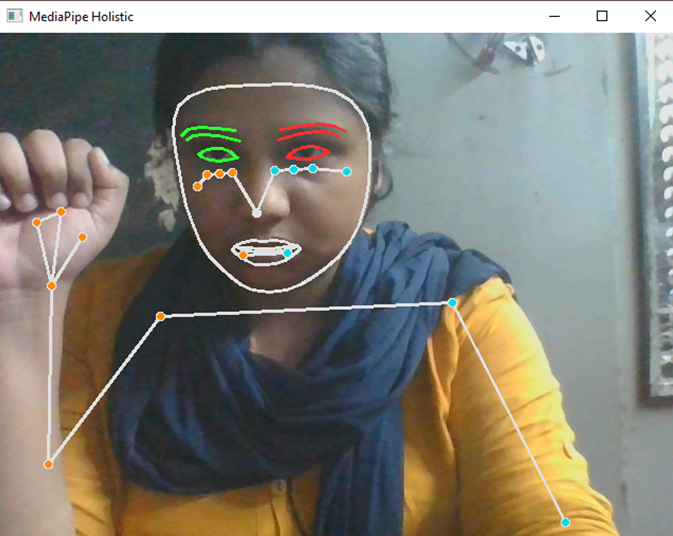